<a href="https://colab.research.google.com/github/ParthikB/siamese/blob/master/siamese_paper_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook, tqdm
import seaborn as sns
import random, os

%matplotlib inline

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


# DATASET Manipulation

## Slicing and Labeling

In [0]:
def resize_image(img, row, col, slice):
  return cv2.resize(img, (col-col%slice, row-row%slice))
  
# Getting a single slice according to the current coordinates
def get_slice(img, start_row, end_row, start_col, end_col):
  return img[start_row:end_row, start_col:end_col]

# Dividing the Image into smaller slices
def get_slice_list(img, slice_size):
  
  w, h = img.shape
  nw, nh = w//slice_size, h//slice_size

  slices = []
  for i in range(nw):
    for j in range(nh):
      start_row = slice_size*i 
      start_col = slice_size*j
      end_row   = start_row + slice_size 
      end_col   = start_col + slice_size

      # print(start_row, end_row, start_col, end_col) 

      slice = get_slice(img, start_row, end_row, start_col, end_col)
      slices.append(slice)
      
  # print(f'Total Slices : {len(slices)}')  
  return slices

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data_path = '/content/drive/My Drive/Colab Notebooks/siamese_paper/dataset/custom/'
os.chdir(data_path)
labels = os.listdir()

SLICE = 16

dataset = []

for label in tqdm(labels):
  # print(label, sorted(os.listdir(label)))

  for i in range(1, len(os.listdir(label))//2 + 1):
    ##### Reading the Images #####
    ir_img  = plt.imread(f'{label}/IR_{i}.bmp')
    vis_img = plt.imread(f'{label}/VIS_{i}.bmp')

    row, col = ir_img.shape
    # print('Image Original Dimensions :', ir_img.shape)

    ##### Resizing the Images #####
    ir_img  = resize_image(ir_img,  row, col, slice=SLICE)
    vis_img = resize_image(vis_img, row, col, slice=SLICE)
    
    # print('Image Resized Dimensions  :', ir_img.shape)
    ROW, COL = ir_img.shape
    

    ##### Slicing the images #####
    ir_slices = []
    vis_slices = []

    ir_slices  = get_slice_list(ir_img, SLICE)
    vis_slices = get_slice_list(vis_img, SLICE)


    ##### Zipping the two slices in tensor format, and adding the label ####
    for ir_slice, vis_slice in zip(ir_slices, vis_slices):
      
      # Adding a Batch-Dimension
      ir_slice  = ir_slice[None, :, :]
      vis_slice = vis_slice[None, :, :]
      
      # Converting to Tensor
      features  = [torch.Tensor(ir_slice), torch.Tensor(vis_slice)]
  
      # Add the zip to the main dataset
      dataset.append([features, torch.tensor(int(label))])

# np array =
# dataset
#       |
#       |- features
#       |         |
#       |         |- ir_slice
#       |         |- vis_slice
#       |
#       |- label (0/1)

# 9040 such pairs

100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


## Converting the Dataset into Torch Dataloader

In [0]:
BATCH_SIZE = 1
CLASSES    = 2

TEST_PERCENT = 20

upto = len(dataset)//TEST_PERCENT

# Shuffling the Dataset
random.shuffle(dataset)

train_data = dataset[upto:]
test_data  = dataset[:upto]

# print(len(train_data), len(test_data))

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

## Checking the Balance

In [6]:
positive = 0

for i, data in enumerate(trainSet.dataset):
  label = data[1]
  if label.item() == 1:
    positive += 1


print('Number of Positive Samples :', positive)
print('Number of Negetive Samples :', len(trainSet.dataset)-positive)

Number of Positive Samples : 4302
Number of Negetive Samples : 4286


torch.Size([1, 16, 16])
Sample Number : 2433
Label         : 1


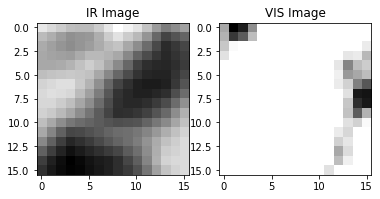

In [7]:
i = np.random.randint(len(trainSet)) # a random sample from the first batch

d = trainSet.dataset

img1, img2, label = d[i][0][0], d[i][0][1], d[i][1]

CHANNELS, DIM, DIM = img1.shape
TOTAL_PIXELS = DIM*DIM
print(img1.shape)

plt.subplot(1, 2, 1)
plt.imshow(img1.view(DIM, DIM), cmap='gray') # Reshaping x from (1, DIM, DIM) --> (DIM, DIM)
plt.title('IR Image')

plt.subplot(1, 2, 2)
plt.imshow(img2.view(DIM, DIM), cmap='gray') # Reshaping x from (1, DIM, DIM) --> (DIM, DIM)
plt.title('VIS Image')

print('Sample Number :', i)
print('Label         :', label.item())

# 0 --> not same
# 1 --> same

# Creating the Net

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()


    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32, kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    # print('total', TOTAL_PIXELS)
    self.fc1   = nn.Linear(self.flatten, 2)
    # self.fc2   = nn.Linear(2, 1)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))
    # print(x.shape)

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
      # print('flatten', self.flatten)
    return x

  def get_sim_score(self, img1, img2):
    return F.pairwise_distance(img1.view(-1,  1), img2.view(-1,  1), keepdim=True).float()

  
  # FORWARD PASS
  def forward(self, x):

    features = {}
    for img, type_ in zip(x, ['IR', 'VIS']):
      img = img.to(device)
      img = self.convs(img)
      img = img.view(self.flatten, -1)
      features[type_] = img

    ir_slice = features['IR']
    vis_slice = features['VIS']

    # CONCATINATION
    # Getting the Euclidian Distance
    # print('Slice', ir_slice.shape)
    edist = self.get_sim_score(ir_slice, vis_slice)

    sm    = edist.view(-1, self.flatten)
    # print('sm', sm.shape)

    fc1 = F.relu(self.fc1(sm))
    # print(fc1)
    label = F.softmax(fc1, dim=1)
    # print(label)
    # # x = self.fc2(sm)

    return label, sm

##fdsf

In [0]:
def train(net, train_set, loss_log=[], lr_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc=f'Iteration > {epoch+1}/{EPOCHS} : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        # output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        output, sm = net(x)

        
        # Compute Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()

        LEARNING_RATE -= LEARNING_RATE*0.0005


    loss_log.append(loss)
    lr_log.append(LEARNING_RATE)
  
  return loss_log, lr_log



def test(net, test_set, find_accuracy=True):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  accuracy = 0
  sm_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      # prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
      prediction_in_batch, sm = net(x)

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)

        sm_log.append([sm, real_class])

        if find_accuracy:
          total += 1
          if real_class == pred_class:
            correct += 1

  if find_accuracy:
    accuracy = (correct/total)*100
    print()
    print(f'Test Accuracy : {round(accuracy, 2)} %')
  
  return accuracy, sm_log

# Training

Initiating Training..



Total Epochs : 5


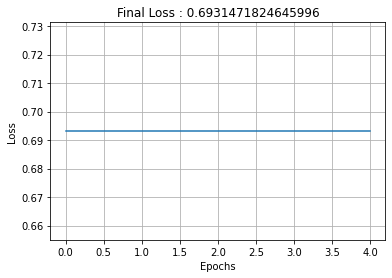

In [15]:
EPOCHS        = 5
LEARNING_RATE = 0.001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  lr_log   = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log, lr_log = train(net, trainSet, loss_log, lr_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.title(f'Final Loss : {loss_log[-1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# accuracy, sm_log = test(net, testSet, find_accuracy=True)

print(f'Total Epochs : {total_epochs}')

In [18]:
accuracy, sm_log = test(net, testSet, find_accuracy=True)


Initiating Testing..




Test Accuracy : 48.23 %


Text(0, 0.5, 'Loss')

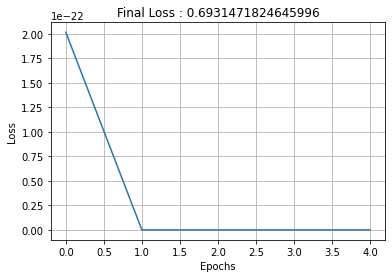

In [12]:
plt.plot(lr_log)
plt.grid(1)
plt.title(f'Final LR : {lr_log[-1]}')
plt.xlabel('Epochs')
plt.ylabel('LR')

In [13]:
lr_log

[2.016589234029697e-22,
 4.066632138804518e-41,
 8.200726589872347e-60,
 1.6537496952357712e-78,
 3.334933831192336e-97]

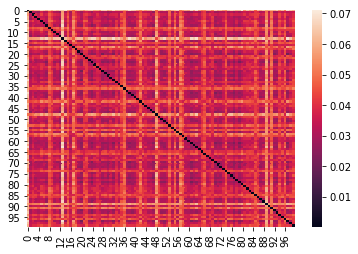

In [0]:
def mean(list):
  return sum(list)/len(list)

# CREATING A DICT THAT CONTAINS THE RESPECTIVE SM
classes = {}

for data in (sm_log):
  sm, label = data
  label = label.numpy()
  sm = sm.cpu().numpy()
  
  try:
    classes[str(label)].append(sm)
  except:
    classes[str(label)] = [sm]


# FINDING THE MINIMUM SAMPLES to CLIP
clip = 1000
for i in classes.keys():
  clip = min(clip, len(classes[i]))


# CLIPPING ALL THE CLASSES SAMPLES TO THE MINIMUM
for i in classes.keys():
  classes[i] = classes[i][:clip]

# CREATING A MASTER IN ORDER
master = []
for c in sorted(classes.keys()):
  master.append(np.array(classes[c]))

# CREATING A MAP LIST TO PLOT
edist_log=[]
for class1 in master:
  class1 = torch.Tensor(class1.mean(axis=1))
  for class2 in master:
    class2 = torch.Tensor(class2.mean(axis=1))
    edist = F.pairwise_distance(class1.view(-1,  1), class2.view(-1,  1), keepdim = True).float().numpy()
    edist_log.append(edist.mean())

plot_dim = int(np.sqrt(np.array(len(edist_log))))

map = np.array(edist_log).reshape(plot_dim, plot_dim)
sns.heatmap(map)

## Testing

In [0]:
# Feeding the dataset(s) to the Network -> returns the Siamese Layer
_, ir_slice_sm  = test(net, ir_dataset, find_accuracy=False)
_, vis_slice_sm = test(net, vis_dataset, find_accuracy=False)

# Filtering the output / getting rid of unwanted outputs
def remove_class_type_from_log(log):
  for i in range(len(log)):
    log[i] = log[i][0].cpu().float()
  return log

ir_slice_sm  = remove_class_type_from_log(ir_slice_sm)
vis_slice_sm = remove_class_type_from_log(vis_slice_sm)

Initiating Testing..



Initiating Testing..


Text(0.5, 1.0, 'VIS Slice')

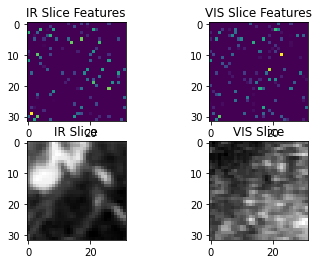

In [0]:
SLICE_NUMBER = 0

plt.subplot(2, 2, 1)
plt.imshow(ir_slice_sm[SLICE_NUMBER].reshape(32, 32))
plt.title('IR Slice Features')

plt.subplot(2, 2, 2)
plt.imshow(vis_slice_sm[SLICE_NUMBER].reshape(32, 32))
plt.title('VIS Slice Features')

plt.subplot(2, 2, 3)
plt.imshow(ir_slices[SLICE_NUMBER], cmap='gray')
plt.title('IR Slice')

plt.subplot(2, 2, 4)
plt.imshow(vis_slices[SLICE_NUMBER], cmap='gray')
plt.title('VIS Slice')

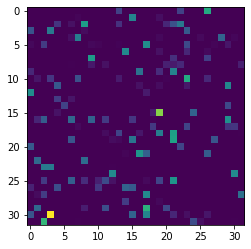

In [0]:
def get_sim_score(img1, img2):
    return F.pairwise_distance(img1.view(-1,  1), img2.view(-1,  1), keepdim=True).float().numpy()

# Getting the Euclidian Distance
edist = get_sim_score(ir_slice_sm[SLICE_NUMBER], vis_slice_sm[SLICE_NUMBER])

plt.imshow(edist.reshape(32, 32))

In [0]:
# Getting the Euclidian distance for the whole images (all the slices stiched back together)
sim_score_arr = []
for SLICE_NUMBER in range(len(ir_slice_sm)):
  edist = get_sim_score(ir_slice_sm[SLICE_NUMBER], vis_slice_sm[SLICE_NUMBER])
  # print(np.sum(edist.reshape(32, 32)))
  sim_score_arr.append(edist.reshape(32, 32))

In [0]:
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

In [0]:
weight_map = unblockshaped(np.array(sim_score_arr), ROW, COL)
vis_img    = unblockshaped(np.array(vis_slices), ROW, COL)
ir_img     = unblockshaped(np.array(ir_slices), ROW, COL)

print('Reconstructed figure dimensions :', weight_map.shape)

# Normalizing the weight map under range(0, 1)
norm_weight = weight_map
norm_weight *= 255.0/weight_map.max()
norm_weight /= 255.0

Reconstructed figure dimensions : (448, 608)


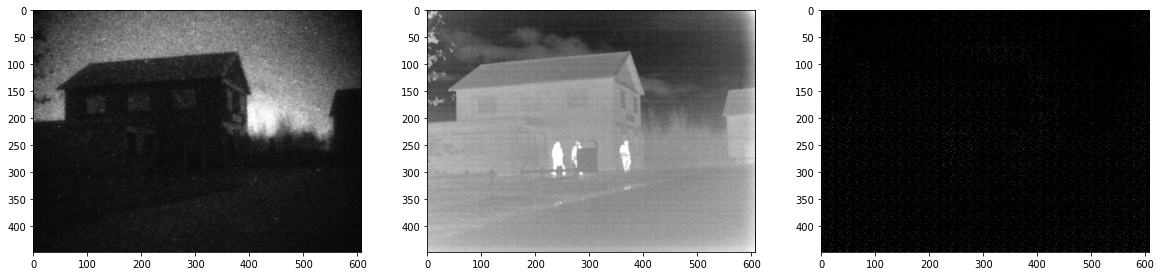

In [0]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(vis_img, cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(ir_img, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(norm_weight/255.0, cmap='gray')

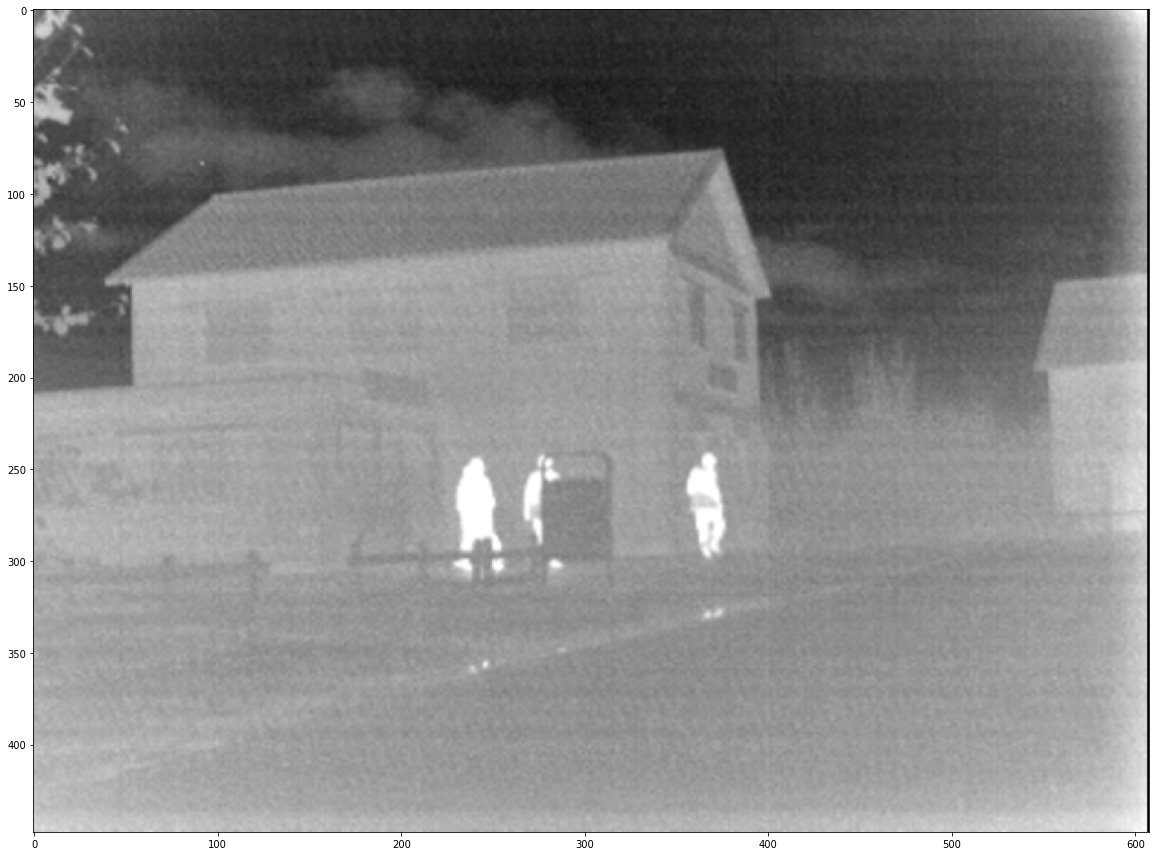

In [0]:
def fuse(weight_map, vis, ir):
  fuse = (weight_map * vis) + ((1-weight_map) * ir)
  return fuse

fused_image = fuse(weight_map, vis_img, ir_img)

plt.figure(figsize=(20, 20))
# plt.imshow(fuse(norm_weight/255.0, ir_img ,vis_img), cmap='gray')
plt.imshow(fuse(norm_weight/255.0, vis_img, ir_img), cmap='gray')

In [0]:
len(sim_score_arr)

266

In [0]:
# loss_contrastive = torch.mean(
#     (1-label) * torch.pow(euclidean_distance, 2) + label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
#             )

def constractive_loss():
  return np.mean(
      (1-label) * np.pow(euclidean_distance, 2) + label * np.pow(np.max(MARGIN - euclidean_distance, 0), 2)
              )